# Spectrum Generation

We use the data to generate spectra for the incidence of particles on the detector

In [1]:
#Include modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from accelerate import parallel, concat
from tqdm.notebook import tqdm

%matplotlib widget

In [2]:
# Read the files

# Parameters
run                     = 'run1'
header                  = ['EventID','TrackID','Particle','InitialEnergy','DepositedEnergy','XPosition','YPosition','ZPosition','LocalTime','Volume']
runid                   = 'run3'

# Find the files
foldername  = f'./data/{run}'
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def loadFile(filename):
    return pd.read_csv(os.path.join(foldername,filename),skiprows=14,names=header)

loadFiles = parallel(loadFile)

files = loadFiles([filename for filename in filenames if runid in filename])

Found 5120 data files in ./data/run1


100%|██████████| 1024/1024 [00:00<00:00, 1097.86it/s]


In [3]:
# Function to extract the energy deposited per track
def getEnergy(data):
    return data.groupby(['EventID','TrackID','Particle'])['DepositedEnergy'].sum().reset_index()

getEnergies = concat(parallel(getEnergy))

# Get the incoming energy of the particles

# Get the deposited energies
energy = getEnergies(files)

# Split into the energy per particle
particleEnergies = {particle:energy.loc[energy.Particle.str.contains(particle)] for particle in energy.Particle.unique()}



100%|██████████| 1024/1024 [00:01<00:00, 544.23it/s]


In [16]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 600
LIMS        = (0,10)
BINS        = np.linspace(*LIMS,NBINS+1)
stackedHist = np.array([np.histogram(particleEnergies[particle].DepositedEnergy,bins=BINS,density=True)[0] for particle in particleEnergies])
color       = np.round(np.random.rand(len(stackedHist),3),1)
[ax.step(BINS[:-1],hist,label=particle,color=c) for hist,particle,c in zip(stackedHist,particleEnergies,color)]

# ax.set_xlim(BINS[1],2)
# ax.set_ylim(0,np.max(,axis=0))
ax.set_ylabel('Density')
ax.set_xlabel('Energy of particles through the detector [keV]')
ax.legend(frameon=False)
# ax.set_yscale('log')
# ax.set_xscale('log')
# fig.savefig('test.png')

print("Unique Particles found are: ",[key for key in particleEnergies])

In [42]:
MATERIAL = {
    'name' : 'Basalt',
    'peaks' : {
        'Fe\nKa' : 6.40,
        'Fe\nKb' : 7.06,
        'Ti\nKa' : 4.51,
        'Ti\nKb' : 4.93,
        'Si\nKa' : 1.74,
        'Al\nKa' : 1.49,
        'Mg\nKa' : 1.25,
        'O\nKa'  : 0.52,
    }
}

# Plot a histogram
def plotParticleHistogram(particleEnergies,PARTICLE = 'gamma',MATERIAL = MATERIAL,source='Cm244',MAX_PEAKS=15,NBINS=1000,LIMS=(0,10)):
    fig = plt.figure(figsize=(10,5))
    ax  = fig.add_subplot(111)

    BINS        = np.linspace(*LIMS,NBINS+1)
    histogram   = np.histogram(particleEnergies[PARTICLE].DepositedEnergy,bins=BINS)[0]
    color       = np.round(np.random.rand(1,3),1)
    ax.step(BINS[:-1],histogram,label=PARTICLE,color=color[0])

    # Get the peaks
    peak_index  = np.argsort(histogram)[-MAX_PEAKS:][::-1]
    peaks       = (BINS[peak_index+1] + BINS[peak_index])/2
    idx_unique  = np.sort(np.unique((peaks*10).astype('int'),return_index=True)[1])
    peak_index  = peak_index[idx_unique]
    peak_height = histogram[peak_index]
    peaks       = peaks[idx_unique] 

    ax.scatter(peaks,peak_height*1.5,c='k',marker = '1')
    for peak,height in zip(peaks,peak_height*1.55):
        ax.annotate("%.2f"%peak,(peak,height),ha='center', va='bottom')

    # Plot the Material peaks
    for peak in MATERIAL['peaks']:
        ax.axvline(MATERIAL['peaks'][peak],ls='--',lw=0.5,c = 'grey')
        ax.annotate(f"{peak}",(MATERIAL['peaks'][peak],ax.get_ylim()[1]),ha='left', va='top',fontsize=10)

    ax.set_xlim(BINS[1],BINS[-1])
    ax.set_xlabel(f'Energy of {PARTICLE} particles through the detector [keV]')
    ax.set_ylabel('Density')
    ax.legend(frameon=False)
    ax.set_yscale('log')
    ax.set_title(f'{MATERIAL["name"]} spectrum by {source} source')

    fig.savefig(source+'.png')

    return fig,ax

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [00:01<00:00, 833.45it/s]


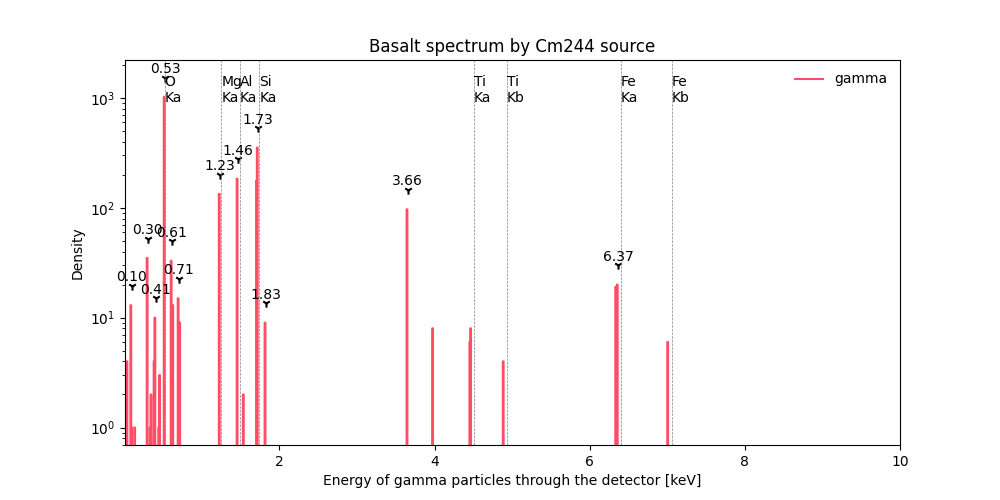

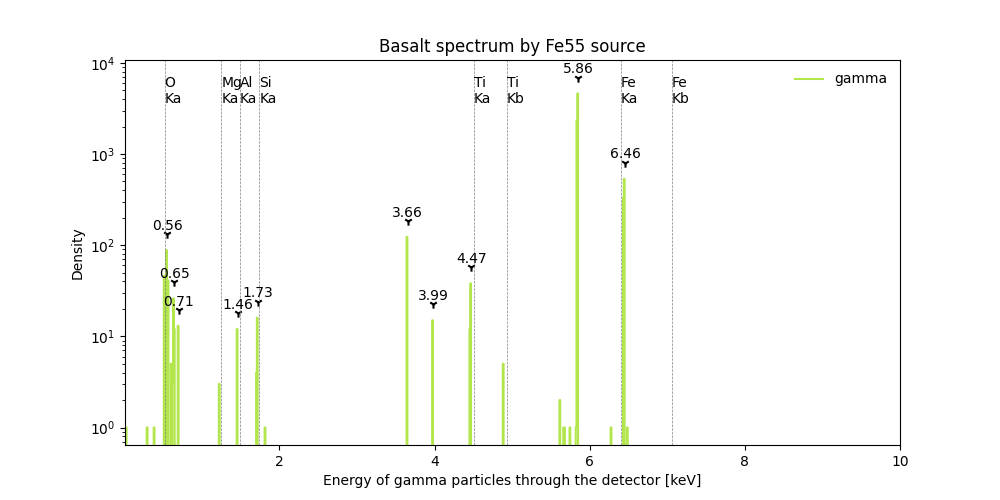

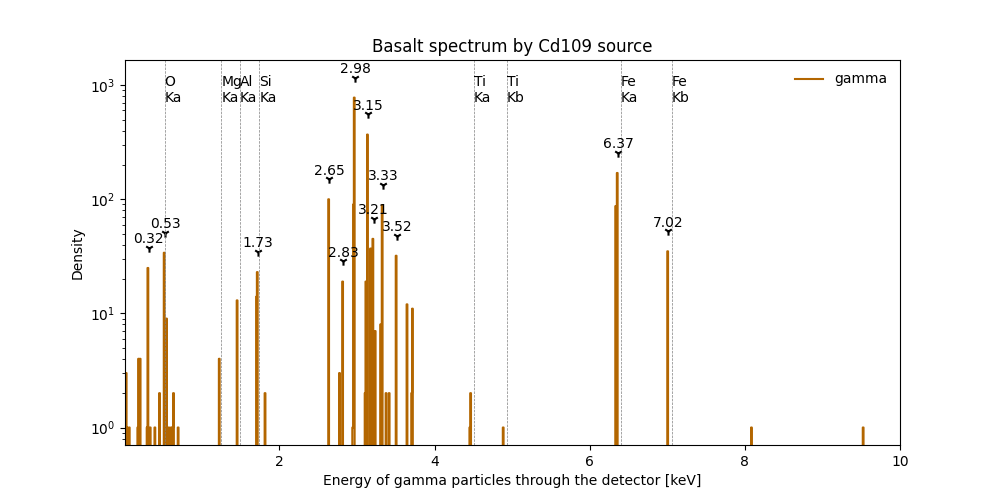

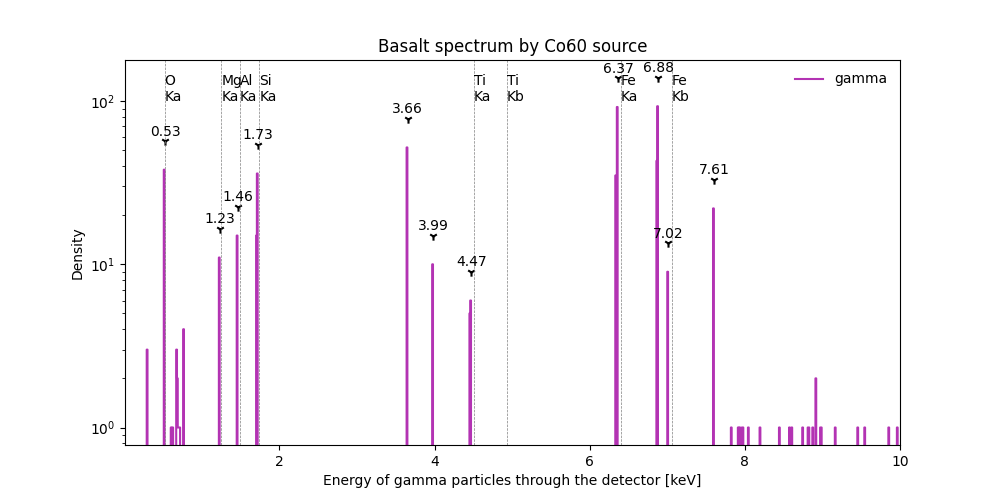

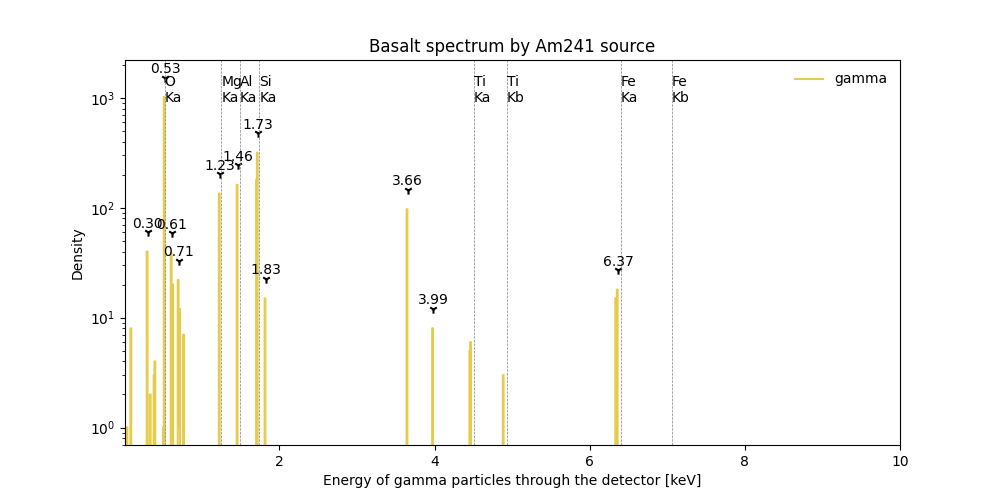

In [44]:
RUN_STRUCTURE = {
    'run0' : 'Cm244',
    'run1' : 'Fe55',
    'run2' : 'Cd109',
    'run3' : 'Co60',
    'run4' : 'Am241'
}

MATERIAL = {
    'name' : 'Basalt',
    'peaks' : {
        'FeKa' : 6.40,
        'FeKb' : 7.06,
        'TiKa' : 4.51,
        'TiKb' : 4.93,
        'SiKa' : 1.74,
        'AlKa' : 1.49,
        'MgKa' : 1.25,
        'OKa'  : 0.52,
    }
}

photon_fraction = {}
photon_mass     = {}

# For all the simulation runs
for run in tqdm(RUN_STRUCTURE):
    # Collect their output files
    files = loadFiles([filename for filename in filenames if run in filename])

    # Read their energy histograms
    energy = getEnergies(files)

    # Extract the energy for each particle
    particleEnergies = {particle:energy.loc[energy.Particle.str.contains(particle)] for particle in energy.Particle.unique()}

    photon_fraction[RUN_STRUCTURE[run]] = len(particleEnergies['gamma'])/len(energy)
    photon_mass[RUN_STRUCTURE[run]]     = len(particleEnergies['gamma'])
    
    # Plot the spectrum
    plotParticleHistogram(particleEnergies,source=RUN_STRUCTURE[run])

In [50]:
print("The relative number of photons received on the detector per source is:") 
photon_rate = {source : photon_mass[source]/max(list(photon_mass.values())) for source in photon_mass}
for source in photon_rate:
    print("%5s: %.4f"%(source,photon_rate[source]))

The relative number of photons received on the detector per source is:
Cm244: 0.0962
 Fe55: 0.3619
Cd109: 1.0000
 Co60: 0.0334
Am241: 0.0936
